# PART 2!
# Time Series Forecasting Youtube Tutorial
## Using Machine Learning to Forecast Energy Consumption



In [10]:
import sys
!{sys.executable} -m pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 20.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 16.8 MB/s eta 0:00:00


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [14]:
df = pd.read_csv('hourly-energy-consumption/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

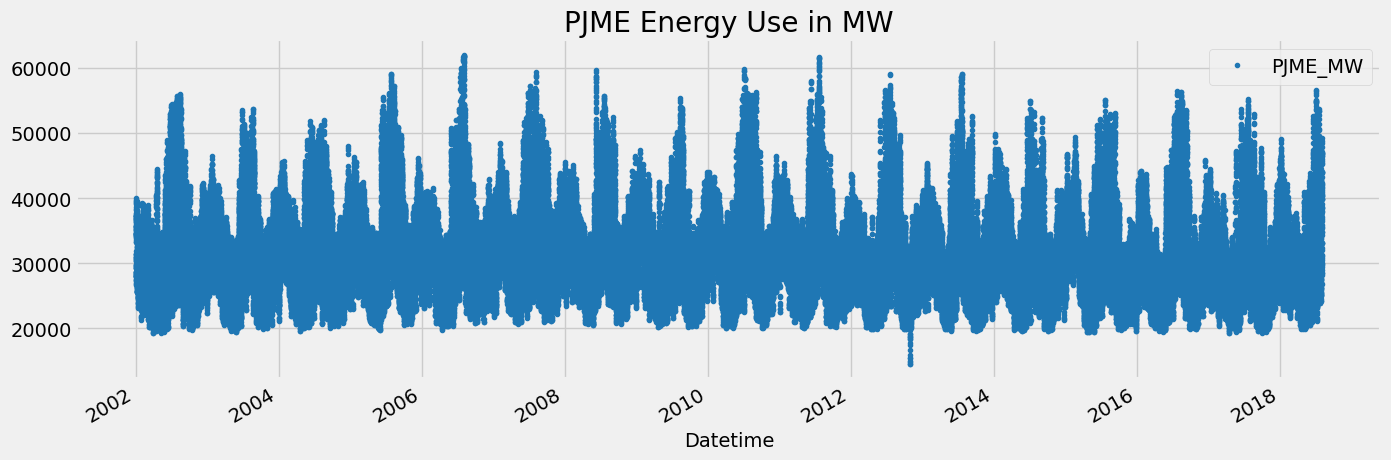

In [15]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

# 1. Outlier Analysis and removal

<Axes: ylabel='Frequency'>

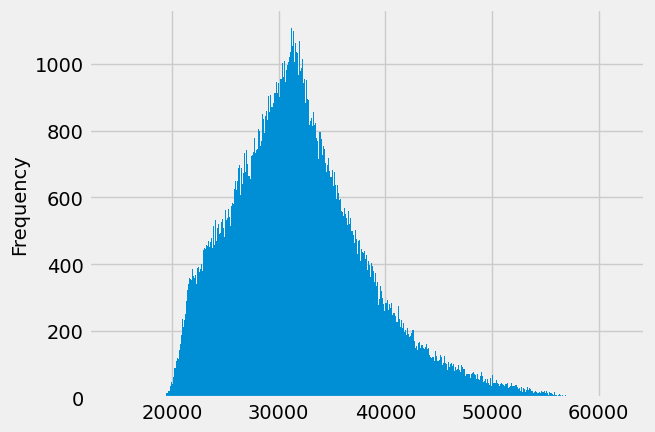

In [16]:
df['PJME_MW'].plot(kind='hist', bins=500)

<Axes: title={'center': 'Outliers'}, xlabel='Datetime'>

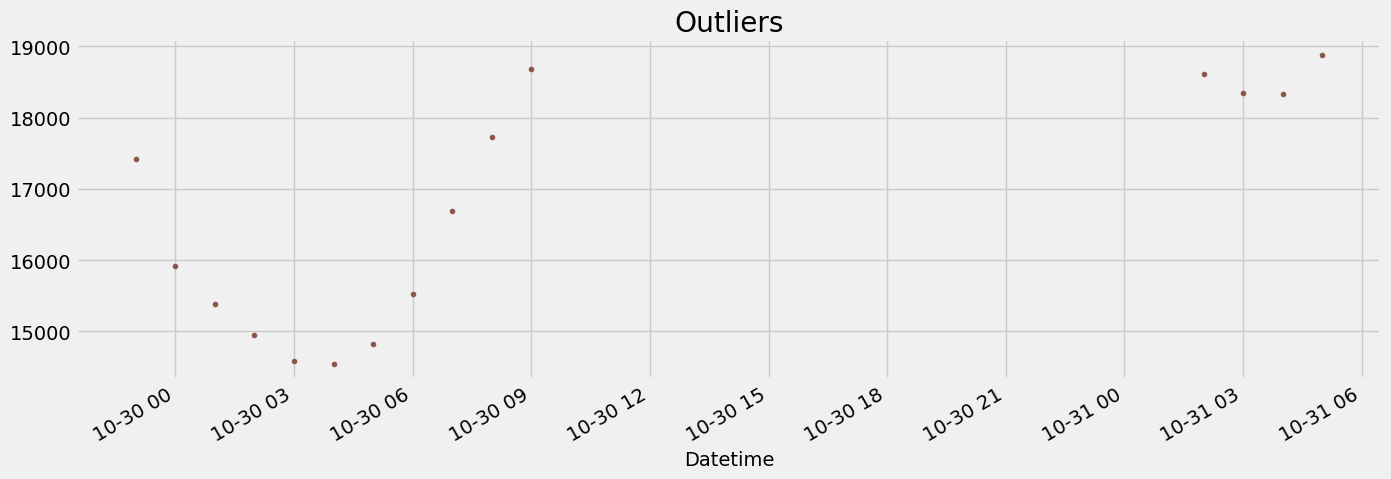

In [17]:
df.query('PJME_MW < 19_000')['PJME_MW'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

In [18]:
df = df.query('PJME_MW > 19_000').copy()

# Reviewing: Train / Test Split

ConversionError: Failed to convert value(s) to axis units: array([Timestamp('2002-01-01 01:00:00'), Timestamp('2002-01-01 02:00:00'),
       Timestamp('2002-01-01 03:00:00'), ...,
       Timestamp('2014-12-31 21:00:00'), Timestamp('2014-12-31 22:00:00'),
       Timestamp('2014-12-31 23:00:00')], dtype=object)

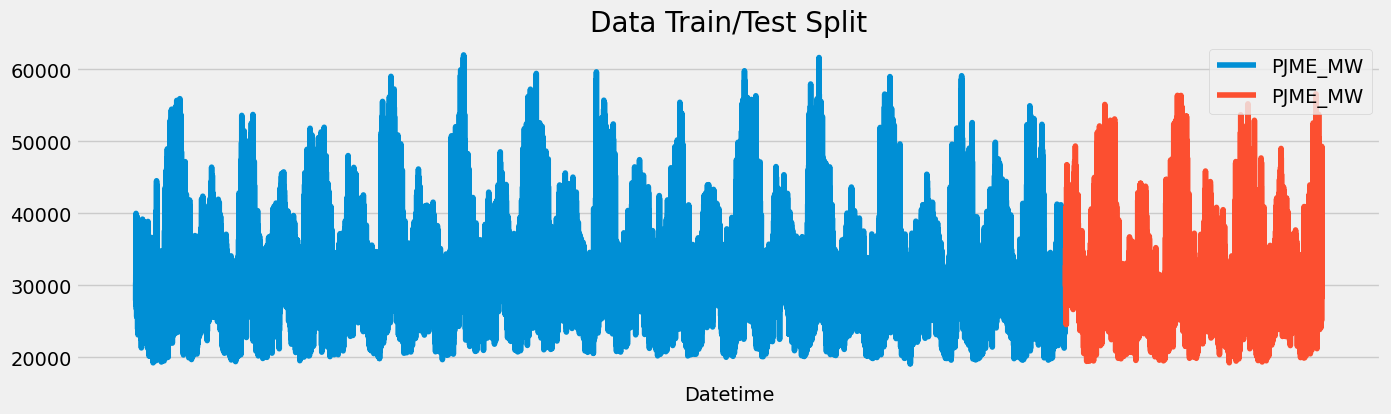

In [19]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

# 1. Time Series Cross Validation

In [20]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

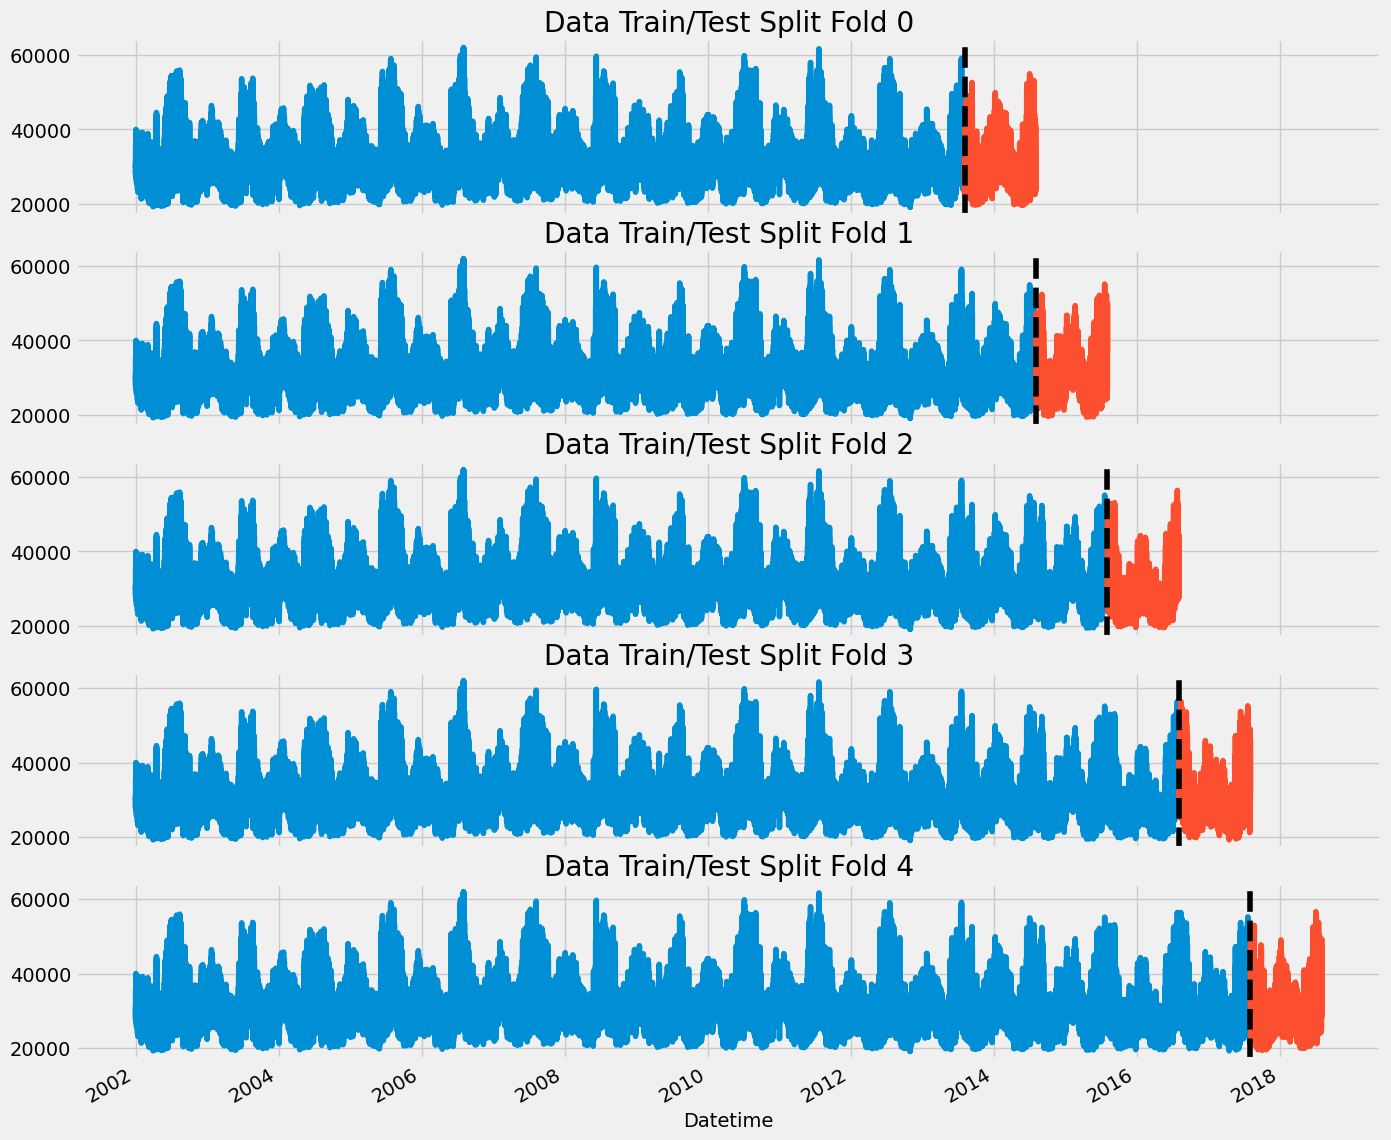

In [21]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

# 2. Forecasting Horizon Explained
**The forecast horizon is the length of time into the future for which forecasts are to be prepared. These generally vary from short-term forecasting horizons (less than three months) to long-term horizons (more than two years).**

In [22]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

# 3. Lag Features
- What was the target (x) days in the past.

In [23]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [24]:
df = add_lags(df)

## Train Using Cross Validation

In [25]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

ImportError: sklearn needs to be installed in order to use this module

In [26]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds nan
Fold scores:[]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# 4. Predicting the Future
- Retraining on all data
- To Predict the future we need an emtpy dataframe for future date ranges.
- Run those dates through our feature creation code + lag creation

In [27]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

ImportError: sklearn needs to be installed in order to use this module

In [28]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [29]:
# Create future dataframe
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [30]:
future_w_features = df_and_future.query('isFuture').copy()

## Predict the future

In [31]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

NameError: name 'reg' is not defined

In [32]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

KeyError: 'pred'

# Bonus: Saving Model For later

In [33]:
# Save model
reg.save_model('model.json')

NameError: name 'reg' is not defined

In [34]:
!ls -lh

total 10848
drwxrwxr-x@  4 shreejitverma  staff   128B Dec 13  2021 ARIMA with Fourier terms
-rw-rw-r--@  1 shreejitverma  staff   173K Oct  7  2020 ARMA Model.ipynb
-rw-rw-r--@  1 shreejitverma  staff   359K Oct  7  2020 Anomaly Detection.ipynb
-rw-rw-r--@  1 shreejitverma  staff   149K Oct  7  2020 Augmented Dickey-Fuller Test.ipynb
-rw-rw-r--@  1 shreejitverma  staff   7.0K Oct 19  2020 CONTRIBUTING.md
drwxrwxr-x@  6 shreejitverma  staff   192B Dec 13  2021 FB-Prophet
drwxrwxr-x@  4 shreejitverma  staff   128B Dec 13  2021 Finding Best Distribution that Fits Data using Fitter
-rw-rw-r--@  1 shreejitverma  staff   5.7K Oct  7  2020 GARCH Model.ipynb
-rw-rw-r--@  1 shreejitverma  staff   8.3K Oct  7  2020 GARCH Stock Modeling.ipynb
-rw-rw-r--@  1 shreejitverma  staff   7.4K Oct  7  2020 Gmail API Tutorial.ipynb
-rw-rw-r--@  1 shreejitverma  staff   4.4K Oct  7  2020 Google Vision API.ipynb
-rw-rw-r--@  1 shreejitverma  staff    53K Oct  7  2020 Granger Causality.ipynb
-rw-rw-r--@  1 s

In [35]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')
future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1, lw=1,
                               title='Future Predictions')

ImportError: sklearn needs to be installed in order to use this module

# The End